# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval



## Introducción

RAPTOR es un enfoque novedoso para modelos de lenguaje aumentados con recuperación de información. Este modelo construye una estructura de árbol con diferentes niveles de resumen desde la base hacia arriba, mejorando la recuperación de información al integrar datos a través de documentos extensos en diferentes niveles de abstracción.

## Tabla de Contenido

1. Descripción Detallada de RAPTOR

2. Métodos Utilizados

3. Comparaciones con Otros Métodos

4. Conclusiones

5. Ejemplo de Código

## Descripción Detallada de RAPTOR

RAPTOR mejora la recuperación al integrar información a través de documentos extensos en diferentes niveles de abstracción. Experimentos controlados muestran que RAPTOR ofrece mejoras significativas sobre los modelos de lenguaje aumentados con recuperación tradicionales en varias tareas, incluyendo resultados de última generación en tareas de preguntas y respuestas.

## Métodos Utilizados

RAPTOR utiliza la incrustación recursiva, el agrupamiento y la resumición de fragmentos de texto para construir una estructura de árbol jerárquica. El modelo recupera información de este árbol durante la inferencia, permitiendo la integración de información en varios niveles de abstracción. El agrupamiento se realiza utilizando Modelos de Mezcla Gaussiana (GMMs) con agrupamiento suave, permitiendo que los nodos pertenezcan a múltiples grupos.

## Comparaciones con Otros Métodos

RAPTOR se compara con métodos de recuperación tradicionales como BM25 y DPR, mostrando un rendimiento superior. RAPTOR supera a otros modelos de última generación en conjuntos de datos como QASPER y QuALITY. El estudio incluye comparaciones controladas utilizando diferentes modelos de lenguaje (GPT-3, GPT-4, UnifiedQA) y métodos de recuperación (SBERT, BM25, DPR).

## Conclusiones

La estructura de árbol de RAPTOR permite una recuperación eficiente al equilibrar la comprensión temática con los detalles granulares. La escalabilidad y eficiencia computacional del modelo se demuestran a través de experimentos en varios conjuntos de datos. El estudio incluye un análisis de las alucinaciones en los resúmenes y su impacto en las tareas de preguntas y respuestas.

## Ejemplo de Código

A continuación, se presenta un ejemplo de cómo se podría implementar un modelo de mezcla gaussiana para el agrupamiento de datos, que es una de las técnicas utilizadas por RAPTOR.

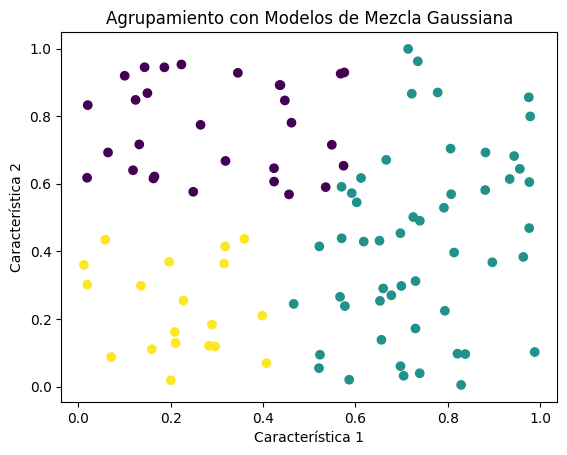

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture



# Generar datos de ejemplo

np.random.seed(0)

X = np.random.rand(100, 2)



# Ajustar el modelo GMM

gmm = GaussianMixture(n_components=3, random_state=0)

gmm.fit(X)

labels = gmm.predict(X)



# Visualizar los resultados

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')

plt.title('Agrupamiento con Modelos de Mezcla Gaussiana')

plt.xlabel('Característica 1')

plt.ylabel('Característica 2')

plt.show()